In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def get_tensor(m=200, n=1000, rank=100, symmetric=False):
    A = torch.randn(m, n)
    u, s, v = torch.svd(A)
    s[rank:] = 0
    s += 1.
    A = u @s.diag() @ v.T
    return A.T@A if symmetric else A

In [3]:
def range_finder(mat, size, r, epsilon, power=0, max_iter=200):
    """Automatic range finder Algo 4.2 from Halko, Martinsson, Tropp 2011"""
    assert isinstance(mat, torch.Tensor) or callable(mat)
    if isinstance(mat, torch.Tensor):
        A = lambda x: mat@x 
    else:
        A = mat
    m, n = size
    omega = torch.randn(n, r)
    omega, _ = torch.qr(omega)
    y = A(omega)
    j = -1

    Q = torch.zeros(m, 0)
    I = torch.eye(m)

    while y[:, j+1:].norm(dim=0).max() > epsilon/(10*np.sqrt(2/np.pi)):
        j = j + 1

        for _ in range(power):  # optional power method to control spectrum
            y[:, j] = A(y[:, j])

        y[:, j] = (I - Q@Q.T) @ y[:, j]

        q = y[:,j]/y[:,j].norm()
        Q = torch.cat([Q, q.unsqueeze(-1)], -1)

        omega2 = torch.randn(n,1)
        y2 = (I - Q@Q.T) @ A(omega2)
        y = torch.cat([y, y2], -1)

        y[:, j+1:j+r] = y[:, j+1:j+r] - Q@Q.T@y[:, j+1:j+r]  # orthogonalize against Q

        if j == max_iter:
            break
    
    error_true = ((I - Q@Q.T) @ A(torch.eye(n))).norm(p=2)  # don't have access to this usually
    error_approx = y[:, -1].norm()
    print(error_true,
          error_approx, 
          Q.shape[1],
         j)
    
    return Q

m, n, r_true = 200, 2000, 50
A = get_tensor(m, n, r_true, symmetric=True)
Q1 = range_finder(A, size=(n,n), r=10, power=0, epsilon=1e-1)

tensor(1.2372e-05) tensor(1.1253e-05) 50 49


In [4]:
eigenvalues, vecs = torch.symeig((Q1.T @ A @ Q1), eigenvectors=True, )

eigenvectors = Q1 @ vecs

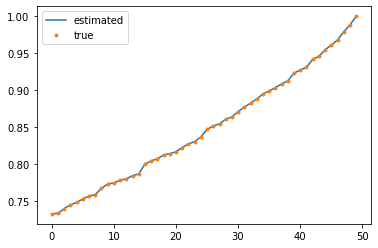

In [5]:
plt.plot((eigenvectors.T @ A @ eigenvectors).diag()[-r_true:], label='estimated')
plt.plot(torch.symeig(A)[0][-r_true:], '.', label='true')
plt.legend()